# Fuzzy Logic for Python 3

The doctests in the modules should give a good idea how to use things by themselves, while here are some examples how to use everything together.

# Installation
First things first: To install fuzzylogic, just enter `python -m pip install fuzzylogic` and you should be good to go!

### Functions and Sets
Defining a domain with its range and resolution should be trivial since most real world instruments come with those specifications. However, defining the fuzzy sets within those domains is where the fun begins as only a human can tell whether something is "hot" or "not", right?

Why the distinction? Functions only map values, nothing special there at all - which is good for testing and performance. Sets on the other hand implement logical operations that have special python syntax, which makes it easy to work with but a little more difficult to test and adds some performance overhead. So, sets are for abstraction and easy handling, functions for performance.

### Domains
You can use (I do so regularly) fuzzy functions outside any specific fuzzy context. However, if you want to take advantage of the logic of fuzzy sets, plot stuff or defuzzyfy values, you need to use Domains. Domains and Sets are special in a way that they intrically rely on each other. This is enforced by how assignments work. Regular Domain attributes are the sets that were assigned to the domain. Also, if just a function is assigned it is automatically wrapped in a Set.

In [1]:
from matplotlib import pyplot
pyplot.rc("figure", figsize=(10, 10))

In [2]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import R, S, alpha

T = Domain("test", 0, 30, res=0.1)

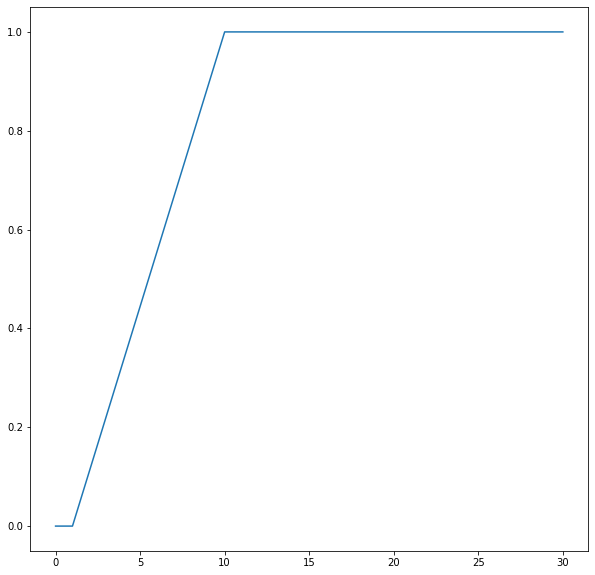

In [5]:
T.up = R(1,10)
T.up.plot()

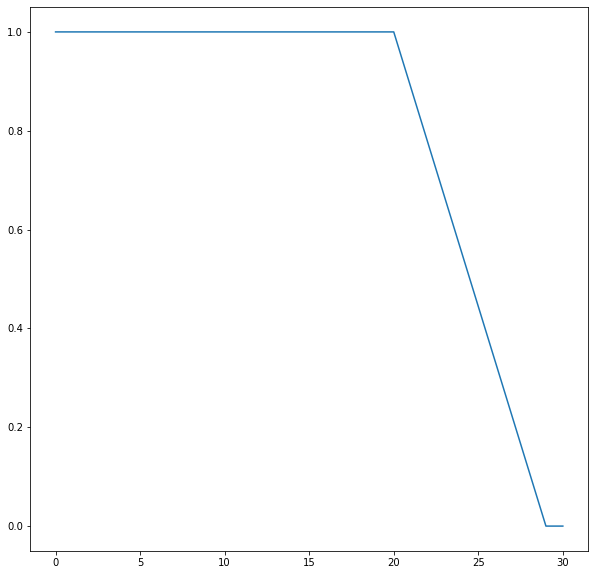

In [6]:
T.down = S(20, 29)
T.down.plot()

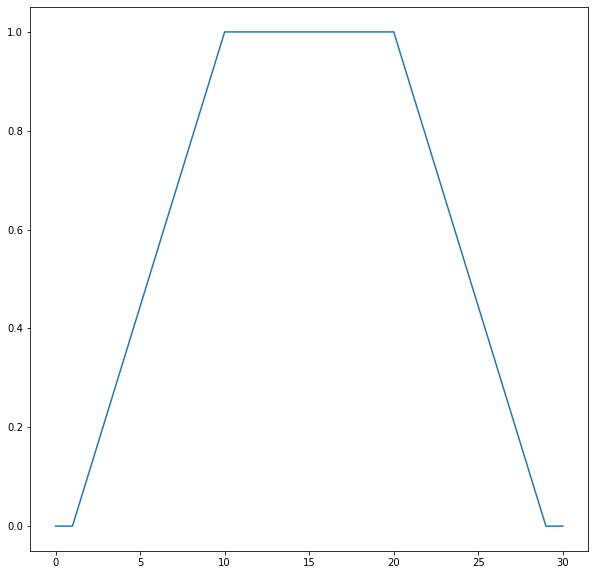

In [7]:
T.polygon = T.up & T.down
T.polygon.plot()

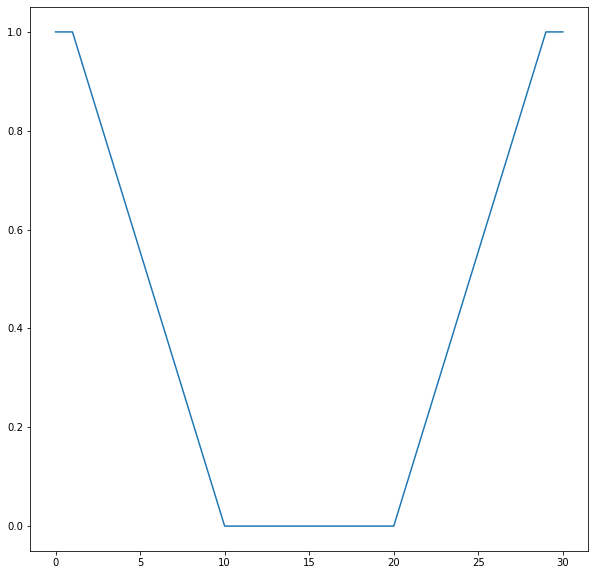

In [8]:
T.inv_polygon = ~T.polygon
T.inv_polygon.plot()

let's show off a few interesting functions ;)

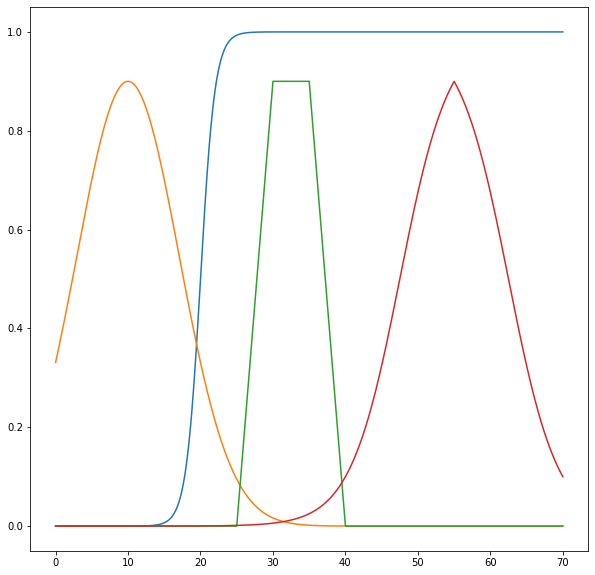

In [9]:
from fuzzylogic.classes import Domain, Set
from fuzzylogic.functions import (sigmoid, gauss, trapezoid, 
                             triangular_sigmoid, rectangular)

T = Domain("test", 0, 70, res=0.1)
T.sigmoid = sigmoid(1,1,20)
T.sigmoid.plot()
T.gauss = gauss(10, 0.01, c_m=0.9)
T.gauss.plot()
T.trapezoid = trapezoid(25, 30, 35, 40, c_m=0.9)
T.trapezoid.plot()
T.triangular_sigmoid = triangular_sigmoid(40, 70, c=55)
T.triangular_sigmoid.plot()

### Domains

After specifying the domain and assigning sets, calling a domain with a value returns a dict of memberships of the sets in that domain.

{Set(<function minus.<locals>.f at 0x7f2ba31c34c0>): 0.5443310539518174,
 Set(<function very.<locals>.f at 0x7f2ba31c3550>): 0.6400000000000001,
 Set(<function bounded_sum.<locals>.f at 0x7f2ba31ba4c0>): 0.8359591794226543}

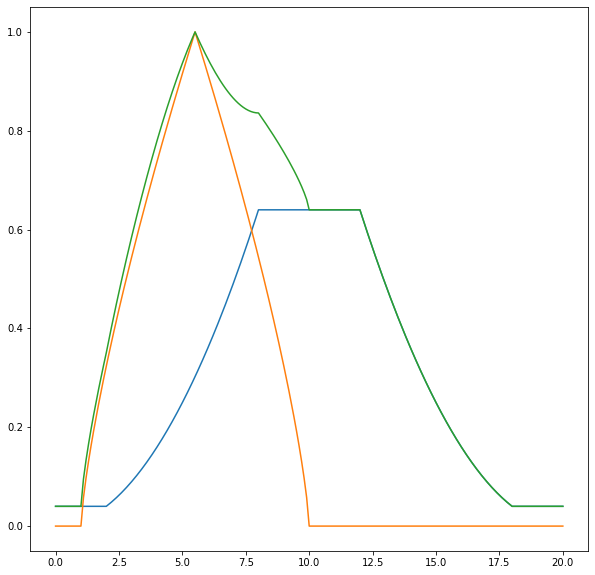

In [10]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import alpha, triangular
from fuzzylogic.hedges import plus, minus, very

numbers = Domain("numbers", 0, 20, res=0.1)

close_to_10 = alpha(floor=0.2, ceiling=0.8, func=triangular(0, 20))
close_to_5 = triangular(1, 10)

numbers.foo = minus(close_to_5)
numbers.bar = very(close_to_10)

numbers.bar.plot()
numbers.foo.plot()
numbers.baz = numbers.foo + numbers.bar
numbers.baz.plot()

numbers(8)

{Set(<function bounded_sigmoid.<locals>.f at 0x7f2ba31baee0>): 0.5,
 Set(<function bounded_sigmoid.<locals>.f at 0x7f2ba305bee0>): 0.012195121951219511,
 Set(<function MIN.<locals>.F at 0x7f2ba3045550>): 0.5}

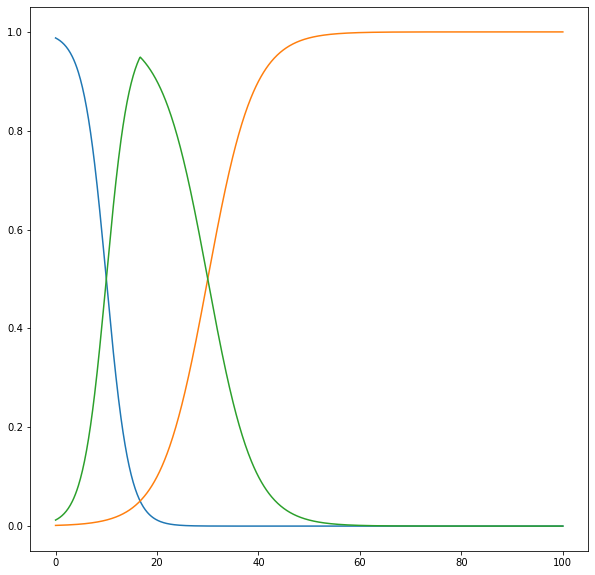

In [11]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import bounded_sigmoid

T = Domain("temperature", 0, 100, res=0.1)
T.cold = bounded_sigmoid(5,15, inverse=True)
T.cold.plot()
T.hot = bounded_sigmoid(20, 40)
T.hot.plot()
T.warm = ~T.hot & ~T.cold
T.warm.plot()
T(10)

Many times you end up with sets that never hit 1 like with sigmoids, triangular funcs that hit the border of the domain or after operations with other sets. Then it is often needed to normalize (define max(set) == 1). Note that Set.normalized() returns a set that (unlike other set ops) is already bound to the domain and given the name "normalized\_{set.name}". This can't be circumvented because normalizing is only defined on a given domain.

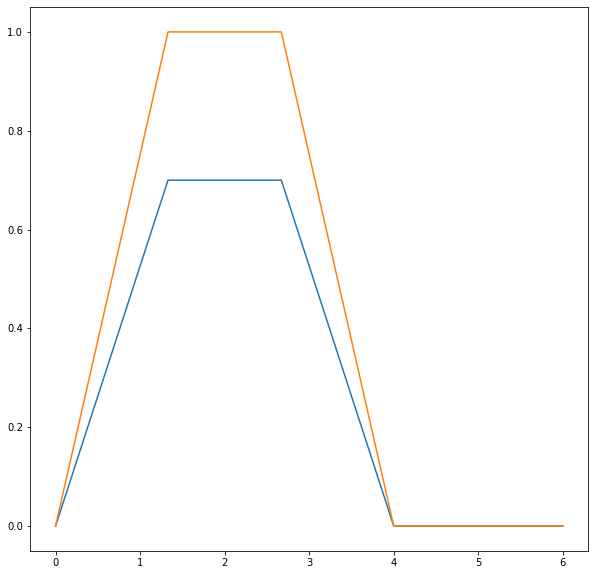

In [12]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import alpha, trapezoid

N = Domain("numbers", 0, 6, res=0.01)
N.two_or_so = alpha(floor=0, ceiling=0.7, func=trapezoid(0, 1.9, 2.1, 4))
N.two_or_so.plot()
N.x = N.two_or_so.normalized()
N.x.plot()

### Inference

After measuring a RL value and mapping it to sets within a domain, it is normally needed to translate the result to another domain that corresponds to some sort of control mechanism. This translation or mapping is called inference and is rooted in the logical conclusion operation A => B, for example: If it rains then the street is wet.
The street may be wet for a number of reasons, but if it rains it will be wet for sure. This **IF A THEN B** can also be written as
***(A AND B) OR NOT(A AND TRUE)***. This may look straight forward for boolean logic, but since we are not just dealing with True and False, there are a number of ways in fuzzy logic to actually implement this.

Here is a simple but fully working example with all moving parts, demonstrating the use in the context of an HVAC system.

It also demonstrates the three different ways to set up complex combinations of rules: you can either define each rule one by one and then combine them via the | operator, or you can put the rules into a list and use sum(..) to combine them into one in a single step, or you can define one big and complex rule right from the start. Which way best suits your needs depends on how complex each rule is and how/where you define them in your code and whether you need to use them in different places in different combinations.

In [13]:
from fuzzylogic.classes import Domain, Set, Rule
from fuzzylogic.hedges import very
from fuzzylogic.functions import R, S

temp = Domain("Temperature", -80, 80)
hum = Domain("Humidity", 0, 100)
motor = Domain("Speed", 0, 2000)

temp.cold = S(0,20)
temp.hot = R(15,30)

hum.dry = S(20,50)
hum.wet = R(40,70)

motor.fast = R(1000,1500)
motor.slow = ~motor.fast

R1 = Rule({(temp.hot, hum.dry): motor.fast})
R2 = Rule({(temp.cold, hum.dry): very(motor.slow)})
R3 = Rule({(temp.hot, hum.wet): very(motor.fast)})
R4 = Rule({(temp.cold, hum.wet): motor.slow})

rules = Rule({(temp.hot, hum.dry): motor.fast,
              (temp.cold, hum.dry): very(motor.slow),
              (temp.hot, hum.wet): very(motor.fast),
              (temp.cold, hum.wet): motor.slow,
             })

rules == R1 | R2 | R3 | R4 == sum([R1, R2, R3, R4])

values = {hum: 45, temp: 22}
print(R1(values), R2(values), R3(values), R4(values), "=>", rules(values))

1610.5651371516108 None 1655.6798260836274 None => 1633.122481617619


There are a few things to note in this example. Firstly, make sure to pass in the values as a single dictionary at the end, not as parameters.
If a rule has zero weight - in this example a temp of 22 results in cold weighted with S(0,20) as 0 - the Rule returns None, which makes sure this condition is ignored in subsequent calculations. Also you might notice that the result is a value of 1633, which is way more than motor.fast with R(1000,1500) would suggest. However, since the domain motor is defined between 0 and 2000, the center of gravity method used for evaluation takes many of the values between 1500 and 2000 weighted with 1 into account, giving this slightly unexpected result.

Writing a single Rule or a few this way is explicit and simple to understand, but considering only 2 input variables with 3 Sets each, this already means 9 lines of code, with each element repeated 3 times. Also, most resources like books present these rules as tables or spreadsheets, which can be overly complicated or at least annoying to rewrite as explicit Rules.
To help with such cases, I've added the ability to transform 2D tables into Rules. This functionality uses pandas to import a table written as multi-line string for now, but it would be easy to accept Excel spreadsheets, csv and all the other formats supported by pandas. However, this functionality comes with three potential drawbacks: The content of cells are strings - which has no IDE support (so *typos might slip through*), which are eval()ed - which *can pose a security risk if the table is provided by an untrusted source*. Thirdly, *only rules with 2 input variables can be modelled this way*, unlike 'classic' Rules which allow an unlimited number of input variables.

Please note, the second argument to this function must be the namespace where all Domains, Sets and hedges are defined that are used within the table. This is due to the fact that the evaluation of those names actually happens in a module where those names normally aren't defined.

In [14]:
table = """
            hum.dry             hum.wet
temp.cold   very(motor.slow)    motor.slow
temp.hot    motor.fast          very(motor.fast)
"""
from fuzzylogic.classes import rule_from_table
table_rules = rule_from_table(table, globals())
assert table_rules == rules

As you can see, the above table_rules is equal to the rules as constructed one at a time earlier, but much less verbose. No element had to be repeated and it is much easier to read.

## Sources
* Fuzzy Logic and Control: Software and Hardware Applications, Volume 2

      By: Mohammad Jamshidi; Nader Vadiee; Timothy J. Ross - University of New Mexico
      Publisher: Prentice Hall
      Pub. Date: June 07, 1993
      
* Computational Intelligence - Fuzzy-Tutorial
      
      Prof. Dr. habil. A. Grauel
      
* http://petro.tanrei.ca/fuzzylogic/fuzzy_negnevistky.html
* http://kik.informatik.fh-dortmund.de/abschlussarbeiten/fuzzyControl/operatoren.html
*     Fundamentals of Fuzzy Logic Control – Fuzzy Sets, Fuzzy Rules and Defuzzifications

    Ying Bai and Dali Wang
    
    https://www.researchgate.net/profile/Ying_Bai/publication/225872318_Fundamentals_of_Fuzzy_Logic_Control_-_Fuzzy_Sets_Fuzzy_Rules_and_Defuzzifications/links/0fcfd5057a874858b1000000/Fundamentals-of-Fuzzy-Logic-Control-Fuzzy-Sets-Fuzzy-Rules-and-Defuzzifications.pdf
